In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils
# %aimport ocfeats


In [2]:
from pathlib import Path

import pandas as pd # also openpyxl for xlsx files
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm, trange

from utilsLoaders import read_trc, read_mot
from utils import trc_arm_angles, center_of_mass, center_of_mass_vel
from utils import segment_gait_cycles
from utils import gait_kinematics_cat
from utils import angle_between_all

from numpy.linalg import norm

datadir = Path('./datadir')

def get_trc_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'MarkerData/PostAugmentation/{trial}/{trial}.trc'

def get_mot_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'OpenSimData/Kinematics/{trial}.mot'


In [3]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72


In [4]:
df_session = pd.read_excel(datadir / 'session_info.xlsx', )
df_trial = pd.read_excel(datadir / 'trial_info.xlsx')
df_part = pd.read_excel(datadir / 'participant_info.xlsx')


p014


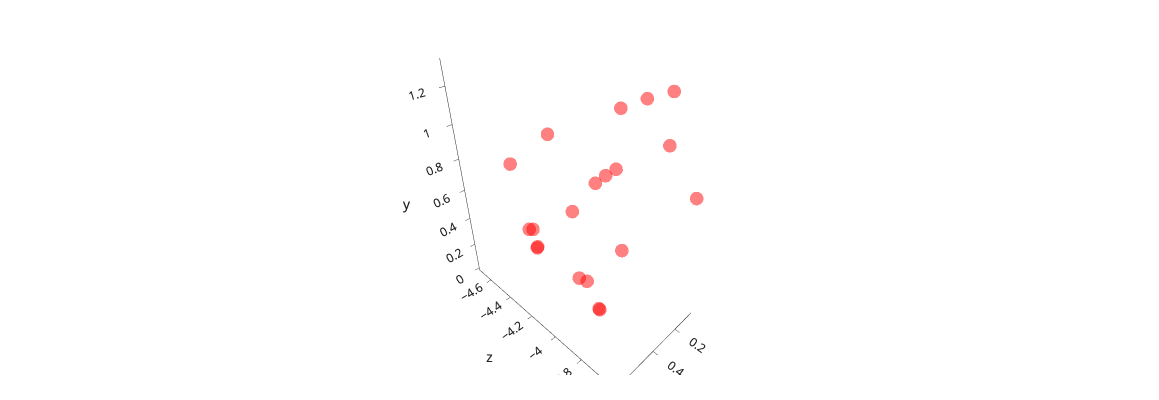

array(['Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow',
       'LWrist', 'midHip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee',
       'LAnkle', 'LBigToe', 'LSmallToe', 'LHeel', 'RBigToe', 'RSmallToe',
       'RHeel'], dtype=object)

In [5]:
import plotly.express as px

pid = 'p014'
# pid = 'p060'
# pid = 'p093'

df_temp = df_trial[df_trial.trial_clean == '10mwrt']
df_temp = df_temp[df_temp.pid == pid]
um = df_temp.sample(1).iloc[0]
pid, sid, trial = um[['pid', 'sid', 'trial']]
print(pid)

fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

if False:
    # TODO hacky COM
    rh = xyz[:,np.argmax(markers=='RHJC_study'),:].copy()
    lh = xyz[:,np.argmax(markers=='LHJC_study'),:].copy()
    com = (rh + lh) / 2

    # compute direction of travel
    direc = com[-1,:] - com[0,:]
    direc /= norm(direc)
    pos_z = np.array([0.0, 1.0, 0.0])
    agrav = pos_z - (pos_z @ direc) / (direc @ direc) * direc
    agrav /= norm(agrav)
    perp = np.cross(agrav, direc)
    perp /= norm(perp)
    new_basis = np.stack([perp, agrav, direc])
    P = np.linalg.inv(new_basis)
    print(new_basis)
    xyz = np.einsum('...ij,jk->...ik', xyz, P)

k = 325
idx = np.where([not m.endswith('study') for m in markers])[0]
# idx = np.where([m.endswith('study') for m in markers])[0]
df_temp = pd.DataFrame({'marker': markers[idx],
                        'x':xyz[k,idx,0],
                        'y':xyz[k,idx,1],
                        'z':xyz[k,idx,2]})
fig = px.scatter_3d(df_temp, x='x', y='z', z='y', hover_data='marker',
                    width=400, height=400,
                    template='simple_white',
                    color_discrete_sequence=['rgba(255,0,0,0.5)'])
fig.update_layout(margin=dict(b=25, t=25, l=25, r=25))
fig.update_layout(scene_aspectmode='data')
fig.show()

markers[idx]


  0%|          | 0/276 [00:00<?, ?it/s]

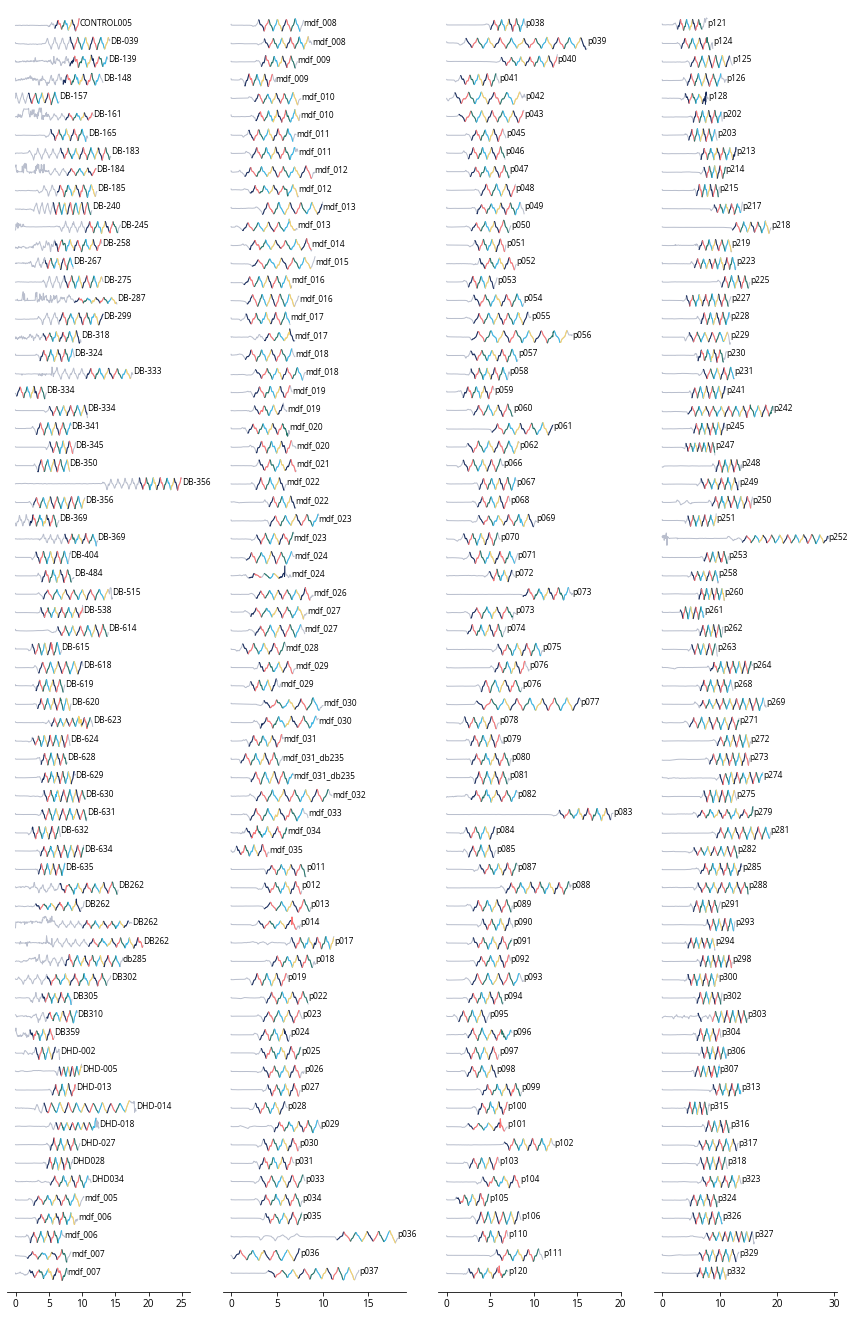

In [6]:
df = df_trial[df_trial.trial_clean=='10mwt']
n = len(df)

ncols = 4

plt.figure(figsize=(3*ncols,n/15))

for i in trange(n, leave=False):
    row = df.iloc[i]
    pid, sid, trial = row.pid, row.sid, row.trial

    # if pid not in ('mdf_005', 'mdf_015', 'mdf_028', 'p095', 'p125'):
        # continue
    
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

    half_cycles, full_cycles, h = segment_gait_cycles(xyz, markers, fps)

    ra = xyz[:,np.argmax(markers=='r_ankle_study'),:].copy()
    la = xyz[:,np.argmax(markers=='L_ankle_study'),:].copy()
    ma = (ra - la)
    h = ma[:,1].copy()    
    h /= h.ptp()

    t = np.arange(h.size) / fps

    plt.subplot(1,ncols,int(i//(n/ncols)+1))
    plt.plot(t, h-i%(n/ncols)*1.5, lw=1, c=cp[0], zorder=-1, alpha=0.3)
    for k, (rl, ll) in enumerate(half_cycles):
        plt.plot(t[rl:ll], h[rl:ll]-i%(n/ncols)*1.5, lw=1, c=cp[k%len(cp)], zorder=1)
    plt.text(t[-1], 0-i%(n/ncols)*1.5, pid, fontsize='small')
    plt.yticks([])
    plt.ylim(-(n/ncols)*1.5, 1.5)

sns.despine(left=True)
plt.tight_layout()
plt.savefig('demo_gait_10mwt.pdf')
plt.show()


  0%|          | 0/274 [00:00<?, ?it/s]

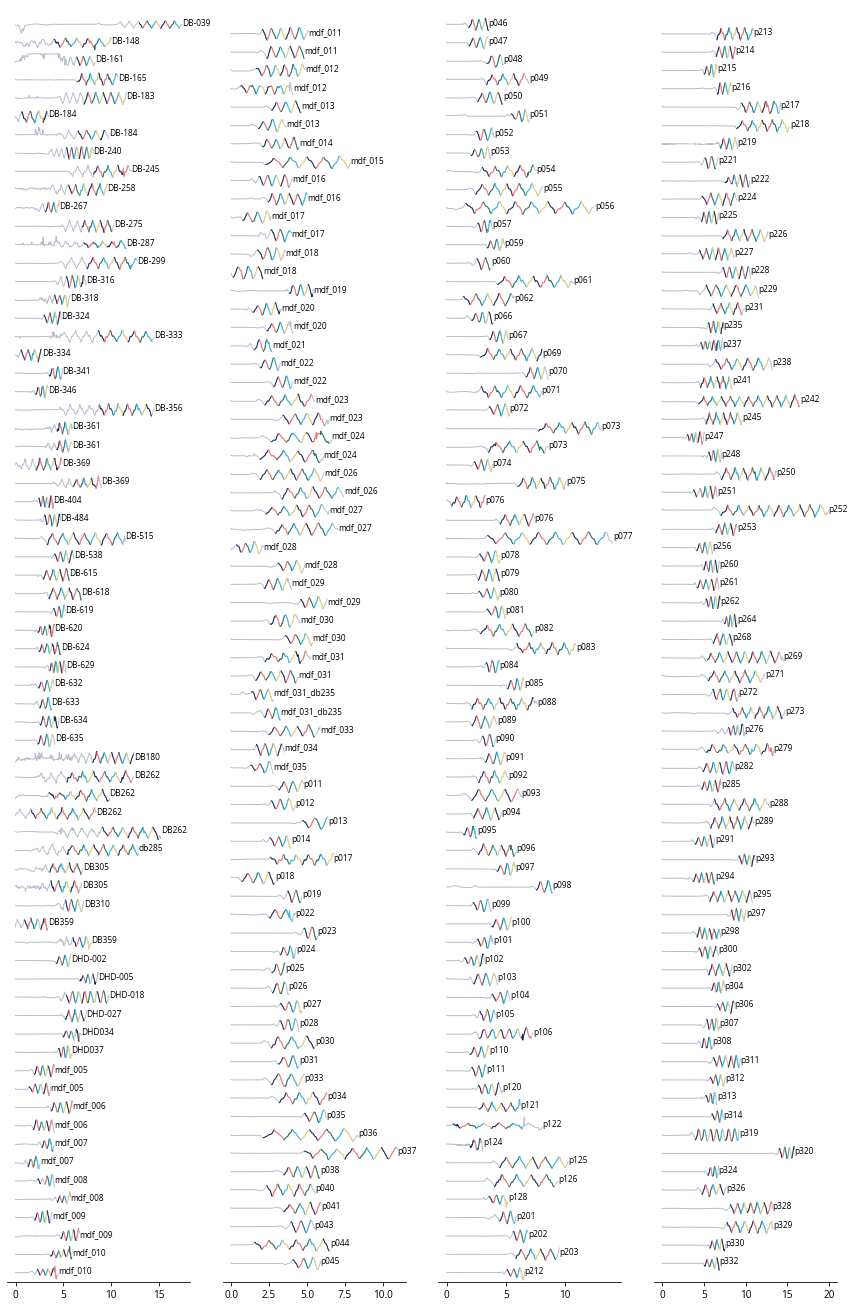

In [7]:
df = df_trial[df_trial.trial_clean=='10mwrt']
n = len(df)

ncols = 4

plt.figure(figsize=(3*ncols,n/15))

for i in trange(n, leave=False):
    row = df.iloc[i]
    pid, sid, trial = row.pid, row.sid, row.trial

    # if pid not in ('mdf_005', 'mdf_015', 'mdf_028', 'p095', 'p125'):
        # continue
    
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

    half_cycles, full_cycles, h = segment_gait_cycles(xyz, markers, fps)

    ra = xyz[:,np.argmax(markers=='r_ankle_study'),:].copy()
    la = xyz[:,np.argmax(markers=='L_ankle_study'),:].copy()
    ma = (ra - la)
    h = ma[:,1].copy()    
    h /= h.ptp()

    t = np.arange(h.size) / fps

    plt.subplot(1,ncols,int(i//(n/ncols)+1))
    plt.plot(t, h-i%(n/ncols)*1.5, lw=1, c=cp[0], zorder=-1, alpha=0.3)
    for k, (rl, ll) in enumerate(half_cycles):
        plt.plot(t[rl:ll], h[rl:ll]-i%(n/ncols)*1.5, lw=1, c=cp[k%len(cp)], zorder=1)
    plt.text(t[-1], 0-i%(n/ncols)*1.5, pid, fontsize='small')
    plt.yticks([])
    plt.ylim(-(n/ncols)*1.5, 1.5)

sns.despine(left=True)
plt.tight_layout()
plt.savefig('demo_gait_10mwrt.pdf')
plt.show()


  0%|          | 0/274 [00:00<?, ?it/s]

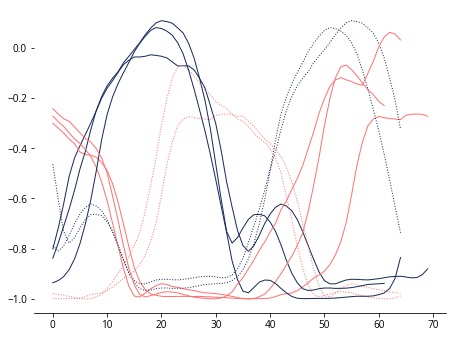

('DHD034', '497aae88-c6a5-44ce-9eeb-a4b222be1158')

In [8]:
df = df_trial[df_trial.trial_clean=='10mwrt']
n = len(df)

ncols = 4

# plt.figure(figsize=(3*ncols,n/15))
for i in trange(n, leave=False):
    row = df.iloc[i]
    pid, sid, trial = row.pid, row.sid, row.trial
    
    if pid != 'DHD034':
        continue
    
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))
    half_cycles, full_cycles, h = segment_gait_cycles(xyz, markers, fps)

    t = np.arange(h.size) / fps
    
    # TODO hacky COM
    rh = xyz[:,np.argmax(markers=='RHJC_study'),:].copy()
    lh = xyz[:,np.argmax(markers=='LHJC_study'),:].copy()
    com = (rh + lh) / 2

    # transform basis
    direc = com[-1,:] - com[0,:]
    direc /= norm(direc)
    pos_z = np.array([0.0, 1.0, 0.0])
    agrav = pos_z - (pos_z @ direc) / (direc @ direc) * direc
    agrav /= norm(agrav)
    perp = np.cross(agrav, direc)
    perp /= norm(perp)
    new_basis = np.stack([perp, agrav, direc])
    P = np.linalg.inv(new_basis)
    xyz = np.einsum('...ij,jk->...ik', xyz, P)
    
    
    ra = xyz[:,np.argmax(markers=='r_mankle_study'),:].copy()

    rs = xyz[:,np.argmax(markers=='r_shoulder_study'),:].copy()
    ls = xyz[:,np.argmax(markers=='L_shoulder_study'),:].copy()
    re = xyz[:,np.argmax(markers=='r_lelbow_study'),:].copy()
    le = xyz[:,np.argmax(markers=='L_lelbow_study'),:].copy()
    rw = xyz[:,np.argmax(markers=='r_lwrist_study'),:].copy()
    lw = xyz[:,np.argmax(markers=='L_lwrist_study'),:].copy()
    ls[:,0] *= -1
    le[:,0] *= -1
    lw[:,0] *= -1
    
    rua = (re - rs)
    lua = (le - ls)
    rla = (rw - re)
    lla = (lw - le)
    rua /= norm(rua, axis=-1, keepdims=True)
    rla /= norm(rla, axis=-1, keepdims=True)
    lua /= norm(lua, axis=-1, keepdims=True)
    lla /= norm(lla, axis=-1, keepdims=True)

    # plt.subplot(1,ncols,int(i//(n/ncols)+1))
    # plt.plot(t, h-i%(n/ncols)*1.5, lw=1, c=cp[0], zorder=-1, alpha=0.3)
    
    # resample width
    W = int(np.mean([lb - la for (la, lb) in full_cycles]))
    r_ipsi = []
    r_contra = []
    l_ipsi = []
    l_contra = []
    for k, (loca, locb) in enumerate(full_cycles):
        if h[loca] < 0:
            r_ipsi.append(ss.resample(rla[loca:locb], W))
            l_contra.append(ss.resample(lla[loca:locb], W))
        else:
            r_contra.append(ss.resample(rla[loca:locb], W))
            l_ipsi.append(ss.resample(lla[loca:locb], W))
        
        plt.plot(rla[loca:locb,1], c=cp[0], ls=('solid' if h[loca] < 0 else 'dotted'), lw=1)
        plt.plot(lla[loca:locb,1], c=cp[1], ls=('solid' if h[loca] < 0 else 'dotted'), lw=1)
    r_mean = np.concatenate([np.array(r_ipsi).mean(0), np.array(r_contra).mean(0)])
    l_mean = np.concatenate([np.array(l_ipsi).mean(0), np.array(l_contra).mean(0)])
    aba = angle_between_all(r_mean, l_mean) * 180 / np.pi
    
    break

sns.despine(left=True)
plt.tight_layout()
# plt.savefig('demo_gait_10mwt.pdf')
plt.show()

pid, sid 


In [9]:
full_cycles

array([[600, 670],
       [635, 700],
       [670, 732],
       [700, 765],
       [732, 797]])

  0%|          | 0/274 [00:00<?, ?it/s]

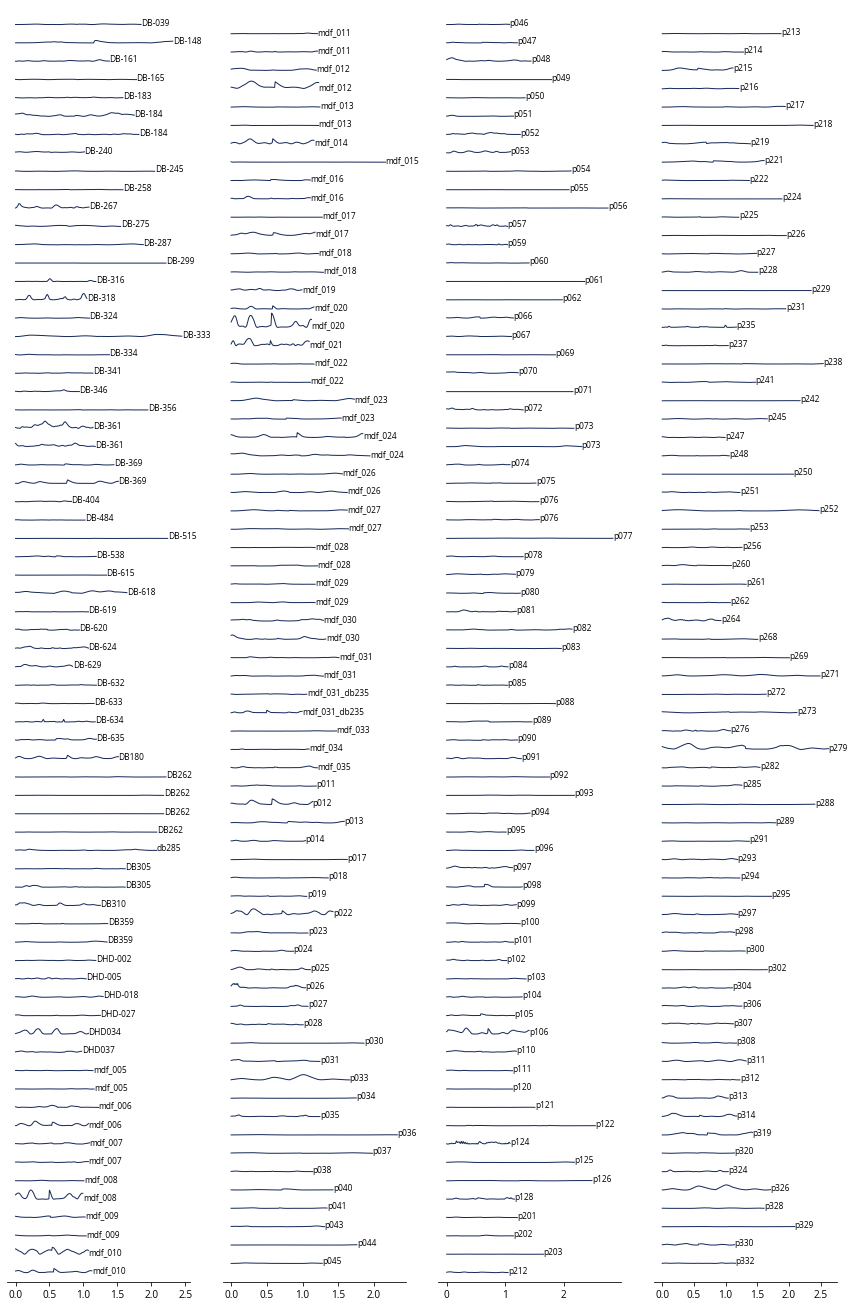

In [10]:
df = df_trial[df_trial.trial_clean=='10mwrt']
n = len(df)

ncols = 4

plt.figure(figsize=(3*ncols,n/15))
for i in trange(n, leave=False):
    row = df.iloc[i]
    pid, sid, trial = row.pid, row.sid, row.trial
    
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))
    half_cycles, full_cycles, h = segment_gait_cycles(xyz, markers, fps)

    t = np.arange(h.size) / fps
    
    # TODO hacky COM
    rh = xyz[:,np.argmax(markers=='RHJC_study'),:].copy()
    lh = xyz[:,np.argmax(markers=='LHJC_study'),:].copy()
    com = (rh + lh) / 2

    # transform basis
    direc = com[-1,:] - com[0,:]
    direc /= norm(direc)
    pos_z = np.array([0.0, 1.0, 0.0])
    agrav = pos_z - (pos_z @ direc) / (direc @ direc) * direc
    agrav /= norm(agrav)
    perp = np.cross(agrav, direc)
    perp /= norm(perp)
    new_basis = np.stack([perp, agrav, direc])
    P = np.linalg.inv(new_basis)
    xyz = np.einsum('...ij,jk->...ik', xyz, P)
    
    rs = xyz[:,np.argmax(markers=='r_shoulder_study'),:].copy()
    ls = xyz[:,np.argmax(markers=='L_shoulder_study'),:].copy()
    re = xyz[:,np.argmax(markers=='r_lelbow_study'),:].copy()
    le = xyz[:,np.argmax(markers=='L_lelbow_study'),:].copy()
    rw = xyz[:,np.argmax(markers=='r_lwrist_study'),:].copy()
    lw = xyz[:,np.argmax(markers=='L_lwrist_study'),:].copy()
    ls[:,0] *= -1
    le[:,0] *= -1
    lw[:,0] *= -1
    
    rua = (re - rs)
    lua = (le - ls)
    rla = (rw - rs)
    lla = (lw - ls)
    rua /= norm(rua, axis=-1, keepdims=True)
    rla /= norm(rla, axis=-1, keepdims=True)
    lua /= norm(lua, axis=-1, keepdims=True)
    lla /= norm(lla, axis=-1, keepdims=True)

    # resample width
    W = int(np.mean([lb - la for (la, lb) in full_cycles]))
    r_ipsi = []
    r_contra = []
    l_ipsi = []
    l_contra = []
    for k, (loca, locb) in enumerate(full_cycles):
        if h[loca] < 0:
            r_ipsi.append(ss.resample(rla[loca:locb], W))
            l_contra.append(ss.resample(lla[loca:locb], W))
        else:
            r_contra.append(ss.resample(rla[loca:locb], W))
            l_ipsi.append(ss.resample(lla[loca:locb], W))
        
    r_mean = np.concatenate([np.array(r_ipsi).mean(0), np.array(r_contra).mean(0)])
    l_mean = np.concatenate([np.array(l_ipsi).mean(0), np.array(l_contra).mean(0)])
    # aba = angle_between_all(r_mean, l_mean) * 180 / np.pi
    aba = np.sum((r_mean - l_mean)**2, axis=1)
    # arm_deviation = np.sqrt(np.mean((r_mean - l_mean)**2))
    
    t = np.arange(aba.shape[0]) / fps
    aba /= 90

    plt.subplot(1,ncols,int(i//(n/ncols)+1))
    plt.plot(t, aba*50-i%(n/ncols)*1.5, lw=1, c=cp[0], zorder=-1, alpha=1)
    plt.text(t[-1], 0-i%(n/ncols)*1.5, pid, fontsize='small')
    plt.yticks([])
    plt.ylim(-(n/ncols)*1.5, 1.5)
    
    # if i > 10:
    #     break

sns.despine(left=True)
plt.tight_layout()
plt.savefig('demo_gait_10mwrt_arm_asym.pdf')
plt.show()


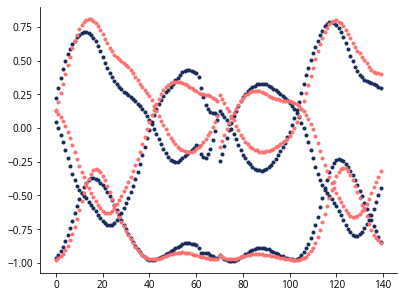

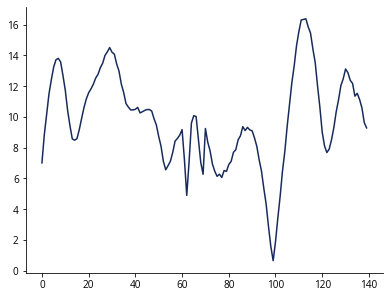

In [11]:
# plt.plot(np.concatenate([r_ipsi, r_contra]), c=cp[0], lw=1)
# plt.plot(np.concatenate([l_ipsi, l_contra]), c=cp[1], lw=1)
plt.plot(r_mean, '.', c=cp[0], lw=1)
plt.plot(l_mean, '.', c=cp[1], lw=1)
plt.show()

aba = angle_between_all(r_mean, l_mean) * 180 / np.pi
plt.plot(aba)
plt.show()



  0%|          | 0/274 [00:00<?, ?it/s]

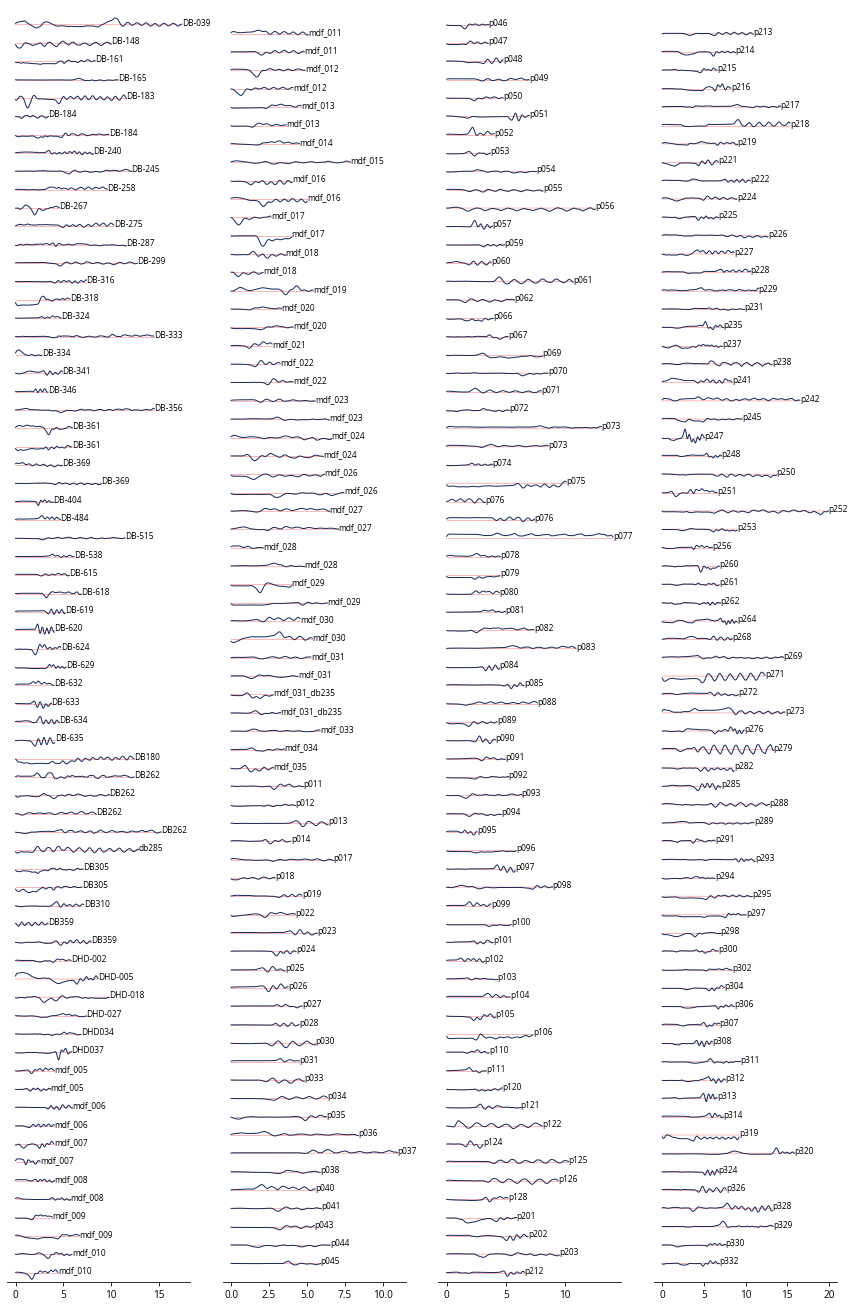

In [12]:
df = df_trial[df_trial.trial_clean=='10mwrt']
n = len(df)

ncols = 4

plt.figure(figsize=(3*ncols,n/15))

for i in trange(n, leave=False):
    row = df.iloc[i]
    pid, sid, trial = row.pid, row.sid, row.trial

    # if pid not in ('mdf_005', 'mdf_015', 'mdf_028', 'p095', 'p125'):
        # continue
    
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))
    
    # TODO hacky COM
    rh = xyz[:,np.argmax(markers=='RHJC_study'),:].copy()
    lh = xyz[:,np.argmax(markers=='LHJC_study'),:].copy()
    com = (rh + lh) / 2
    comv = np.gradient(com, axis=0)
    
    # compute usable kinematics zone
    com_dist = norm((com - com[-2,:])[:,[0,2]], axis=-1)
    zone_start = np.argmax(com_dist < 4)
    zone_stop = np.argmax(com_dist < 1)
    zone = np.arange(xyz.shape[0])
    zone = (zone >= zone_start) & (zone < zone_stop)

    # LP filter kernel
    win = ss.windows.hann(int(0.5*fps))
    win /= np.sum(win)

    # transform to basis aligned with walk direction
    direc = com[-1,:] - com[0,:]
    direc /= norm(direc)
    pos_z = np.array([0.0, 1.0, 0.0])
    agrav = pos_z - (pos_z @ direc) / (direc @ direc) * direc
    agrav /= norm(agrav)
    perp = np.cross(agrav, direc)
    perp /= norm(perp)
    new_basis = np.stack([perp, agrav, direc])
    P = np.linalg.inv(new_basis)
    xyz = np.einsum('...ij,jk->...ik', xyz, P)

    # compute lateral sway
    com_sway = comv[:,0]
    com_sway = ss.convolve(com_sway, win, mode='same')

    # compute lateral lean
    c7 = xyz[:,np.argmax(markers=='r_C7'),:]
    rh = xyz[:,np.argmax(markers=='RHJC_study'),:].copy()
    lh = xyz[:,np.argmax(markers=='LHJC_study'),:].copy()
    midhip = (rh + lh) / 2
    trunk = c7 - midhip
    trunk_tilt = np.arctan2(trunk[:,0], trunk[:,1]) * 180/np.pi
    trunk_tilt = ss.convolve(trunk_tilt, win, mode='same')

    # compute metrics
    time_3m = (zone_stop-zone_start)/fps
    time_10m = time_3m * 10 / 3 # TODO magic numbers
    speed = 3 / time_3m # TODO magic numbers
    com_sway = com_sway[zone].std()
    trunk_lean = np.mean(np.abs(trunk_tilt[zone]))
    trunk_lean_asym = np.abs(np.mean(trunk_tilt[zone]))

    t = np.arange(trunk_tilt.size) / fps

    plt.subplot(1,ncols,int(i//(n/ncols)+1))
    plt.plot(t, trunk_tilt/20-i%(n/ncols)*1.5, lw=1, c=cp[0], zorder=-1, alpha=1)
    plt.plot(t, 0*t-i%(n/ncols)*1.5, lw=1, c=cp[1], zorder=-3, alpha=0.5)
    plt.text(t[-1], 0-i%(n/ncols)*1.5, pid, fontsize='small')
    plt.yticks([])
    plt.ylim(-(n/ncols)*1.5, 1.5)
    
    # if i > 10:
    #     break

sns.despine(left=True)
plt.tight_layout()
plt.savefig('demo_gait_10mwrt_trunk_tilt.pdf')
plt.show()


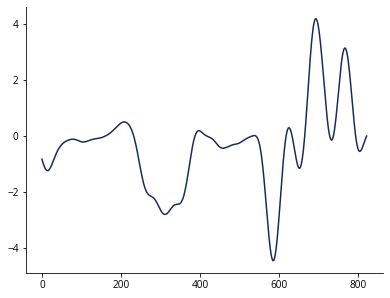

In [13]:
plt.plot(trunk_tilt)

In [14]:
# df = df_trial[df_trial.trial_clean=='10mwrt']
# n = len(df)

# ncols = 4

# plt.figure(figsize=(3*ncols,n/15))

# for i in trange(n, leave=False):
#     row = df.iloc[i] 
#     pid, sid, trial = row.pid, row.sid, row.trial
    
#     fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))
#     half_cycles, full_cycles, h = segment_gait_cycles(xyz, markers, fps)

#     modelPatbh = datadir/f'opencap_data/{sid}/OpenSimData/Model/LaiUhlrich2022_scaled.osim'
#     com = center_of_mass(modelPath, get_mot_fpath(sid, trial))
#     comv = center_of_mass_vel(modelPath, get_mot_fpath(sid, trial))

#     com -= com[-1,:]

#     # compute direction of travel
#     com_xz = com[:,[0,2]].copy()
#     direction = com_xz[0,:] - com_xz[-1,:]
#     direction /= norm(direction)

#     # compute lateral sway
#     comv_xz = comv[:,[0,2]].copy()
#     comv_xz -= np.outer(comv_xz @ direction, direction)
#     com_sway = comv_xz[:,0]
#     win = ss.windows.hann(int(0.5*fps))
#     win /= np.sum(win)
#     com_sway = ss.convolve(com_sway, win, mode='same')

#     # compute usable kinematics zone
#     com_dist = norm(com[:,[0,2]], axis=-1)
#     zone_start = np.argmax(com_dist < 3.5)
#     zone_stop = np.argmax(com_dist < 0.5)
#     zone = np.arange(xyz.shape[0])
#     zone = (zone >= zone_start) & (zone < zone_stop)

#     # compute metrics
#     time_3m = (zone_stop-zone_start)/fps
#     time_10m = time_3m * 10 / 3
#     speed = 3 / time_3m
#     # com_sway = com_sway[zone].std()

#     t = np.arange(xyz.shape[0]) / fps

#     plt.subplot(1,ncols,int(i//(n/ncols)+1))
#     plt.plot(t, com_sway-i%(n/ncols)*1.5, lw=1, c=cp[0], zorder=-1, alpha=0.3)
#     for k, (rl, ll) in enumerate(half_cycles):
#         plt.plot(t[rl:ll], com_sway[rl:ll]-i%(n/ncols)*1.5, lw=1, c=cp[k%len(cp)], zorder=1)
#     plt.text(t[-1], 0-i%(n/ncols)*1.5, pid, fontsize='small')
#     plt.yticks([])
#     plt.ylim(-(n/ncols)*1.5, 1.5)

# sns.despine(left=True)
# plt.tight_layout()
# plt.savefig('demo_gait2_10mwrt.pdf')
# plt.show()


[array([645, 716]), array([716, 788])]


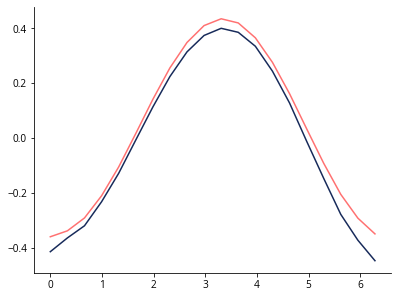

In [15]:
W = 20

r_cycles = [x for x in full_cycles if h[x[0]]>0]
print(r_cycles)
r_cycles = np.array([ss.resample(-h[la:lb], W) for (la, lb) in r_cycles])
mean_r_cycle = np.mean(r_cycles, axis=0)

l_cycles = [x for x in full_cycles if h[x[0]]<0]
l_cycles = np.array([ss.resample(h[la:lb], W) for (la, lb) in l_cycles])
mean_l_cycle = np.mean(l_cycles, axis=0)

theta = np.linspace(0, 2*np.pi, W)
plt.plot(theta, mean_r_cycle)
plt.plot(theta, mean_l_cycle)
plt.show()


In [16]:
markers

array(['Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow',
       'LWrist', 'midHip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee',
       'LAnkle', 'LBigToe', 'LSmallToe', 'LHeel', 'RBigToe', 'RSmallToe',
       'RHeel', 'r.ASIS_study', 'L.ASIS_study', 'r.PSIS_study',
       'L.PSIS_study', 'r_knee_study', 'r_mknee_study', 'r_ankle_study',
       'r_mankle_study', 'r_toe_study', 'r_5meta_study', 'r_calc_study',
       'L_knee_study', 'L_mknee_study', 'L_ankle_study', 'L_mankle_study',
       'L_toe_study', 'L_calc_study', 'L_5meta_study', 'r_shoulder_study',
       'L_shoulder_study', 'C7_study', 'r_thigh1_study', 'r_thigh2_study',
       'r_thigh3_study', 'L_thigh1_study', 'L_thigh2_study',
       'L_thigh3_study', 'r_sh1_study', 'r_sh2_study', 'r_sh3_study',
       'L_sh1_study', 'L_sh2_study', 'L_sh3_study', 'RHJC_study',
       'LHJC_study', 'r_lelbow_study', 'r_melbow_study', 'r_lwrist_study',
       'r_mwrist_study', 'L_lelbow_study', 'L_melbow_study',
       'L_lwrist

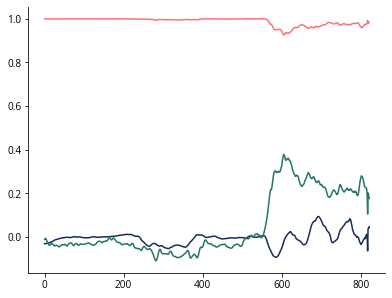

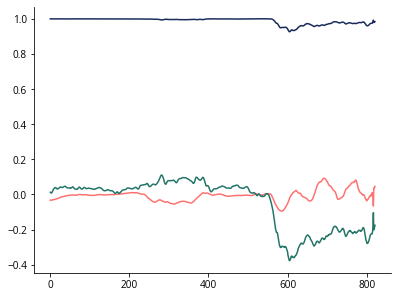

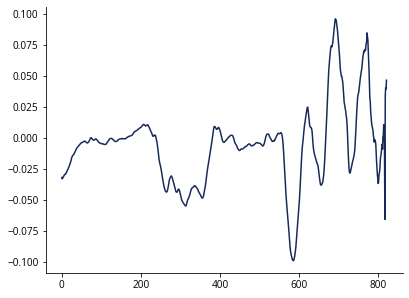

In [17]:
from utils import angle_between_all

rh = xyz[:,np.argmax(markers=='RHJC_study'),:]
lh = xyz[:,np.argmax(markers=='LHJC_study'),:]
com = (rh + lh)/2
com_xz = com[:,[0,2]].copy()
direction = com_xz[0,:] - com_xz[-1,:]
direction /= norm(direction)

direc = np.array([direction[0], 0, direction[1]])
agrav = np.array([0, 1, 0])
perp = np.cross(direc, agrav)
perp /= norm(perp)

new_basis = np.stack([agrav, perp, direc])
P = np.linalg.inv(new_basis)

c7 = xyz[:,np.argmax(markers=='r_C7'),:]
trunk = c7 - com.copy()
trunk /= norm(trunk, axis=1, keepdims=True)
plt.plot(trunk)
plt.show()

trunk = (P @ trunk.T).T
plt.plot(trunk)
plt.show()

trunk_lean_lat = np.arctan2(trunk[:,1], trunk[:,0])
plt.plot(trunk_lean_lat)
plt.show()

# plt.plot(trunk)
# plt.show()



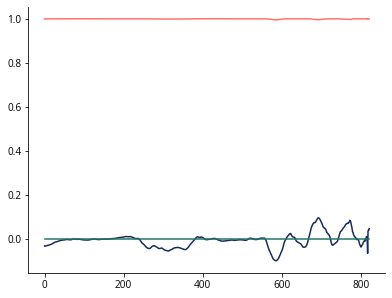

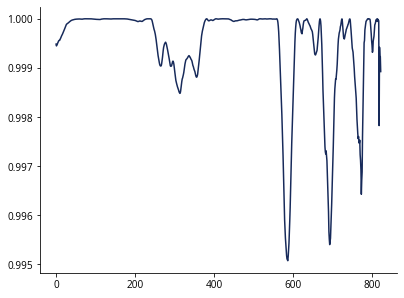

array([[ 1.63634797],
       [ 1.96343523],
       [ 2.22194508],
       [ 1.01812328],
       [-1.25047918]])

In [18]:
from utils import angle_between_all

rh = xyz[:,np.argmax(markers=='RHJC_study'),:]
lh = xyz[:,np.argmax(markers=='LHJC_study'),:]
com = (rh + lh)/2
com_xz = com[:,[0,2]].copy()
direction = com_xz[0,:] - com_xz[-1,:]
direction /= norm(direction)

c7 = xyz[:,np.argmax(markers=='r_C7'),:]
trunk = c7 - com.copy()
trunk[:,[0,2]] -= np.outer(trunk[:,[0,2]] @ direction, direction)
trunk /= norm(trunk, axis=1, keepdims=True)

agrav = np.array([0, 1, 0])
trunk_lean = trunk @ agrav
plt.plot(trunk)
plt.show()
plt.plot(trunk_lean)
plt.show()


com_dist = norm(com[:,[0,2]], axis=-1)
zone_start = np.argmax(com_dist < 4)
zone_stop = np.argmax(com_dist < 1)
zone = np.arange(xyz.shape[0])
zone = (zone >= zone_start) & (zone < zone_stop)

half_cycles, full_cycles, h = segment_gait_cycles(xyz, markers, fps)
stride_time = np.diff(full_cycles, 1).mean() / fps
stride_len = np.diff(com_dist[full_cycles], 1).mean() / fps


np.diff(-com_dist[full_cycles], 1)
    


**Marker Features**
1. R-L ankle height
1. R-L knee height
1. R-L shoulder height
1. R elbow angle
1. L elbow angle

**Kinematic Features**
1. R knee angle
1. L knee angle
1. R hip adduction
1. L hip adduction
1. R hip flexion
1. L hip flexion
1. R shoulder adduction
1. L shoulder adduction
1. R shoulder flexion
1. L shoulder flexion


mdf_005


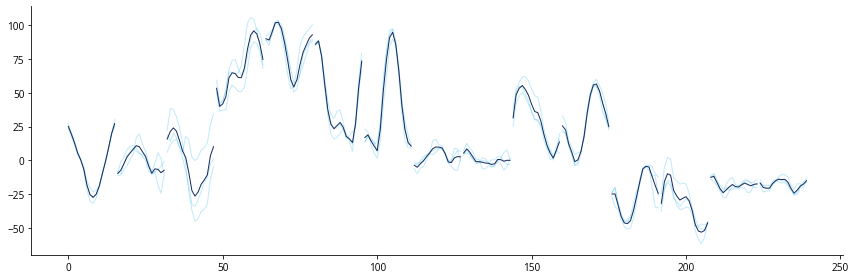

In [19]:
W = 16

pid = 'mdf_005'
# pid = 'p050'
# pid = 'p125'
# pid = 'p060'
# pid = 'p093'

print(pid)
df_temp = df_trial[df_trial.trial_clean == '10mwrt']
df_temp = df_temp[df_temp.pid == pid]
um = df_temp.iloc[0]
pid, sid, trial = um[['pid', 'sid', 'trial']]

fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))
df = read_mot(get_mot_fpath(sid, trial))

half_cycles, full_cycles, h = segment_gait_cycles(xyz, markers, fps)
r_cycles = [x for x in full_cycles if h[x[0]]>0]
l_cycles = [x for x in full_cycles if h[x[0]]<0]

cats = []
for i, (la, lb) in enumerate(r_cycles):

    # TODO normalize by height?

    # ankle height difference
    rah = xyz[:,np.argmax(markers=='r_ankle_study'),1]
    lah = xyz[:,np.argmax(markers=='L_ankle_study'),1]
    rlah = rah - lah
    rlah = ss.resample(rlah[la:lb], W) * 1e2

    # hip height difference
    rhh = xyz[:,np.argmax(markers=='RHJC_study'),1]
    lhh = xyz[:,np.argmax(markers=='LHJC_study'),1]
    rlhh = rhh - lhh
    rlhh = ss.resample(rlhh[la:lb], W) * 1e3

    # shoulder height difference
    rsh = xyz[:,np.argmax(markers=='r_shoulder_study'),1]
    lsh = xyz[:,np.argmax(markers=='L_shoulder_study'),1]
    rlsh = rsh - lsh
    rlsh = ss.resample(rlsh[la:lb], W) * 1e3

    # elbow and shoulder angles
    rsa, rea, lsa, lea = trc_arm_angles(xyz, markers)
    rea = ss.resample(rea[la:lb], W)
    lea = ss.resample(lea[la:lb], W)

    # leg angle kinematics
    rka = ss.resample(df['knee_angle_r'].values[la:lb], W)
    lka = ss.resample(df['knee_angle_l'].values[la:lb], W)
    rha = ss.resample(df['hip_adduction_r'].values[la:lb], W)
    lha = ss.resample(df['hip_adduction_l'].values[la:lb], W)
    rhf = ss.resample(df['hip_flexion_r'].values[la:lb], W)
    lhf = ss.resample(df['hip_flexion_l'].values[la:lb], W)

    # shoulder angle kinematics
    rsf = ss.resample(df['arm_flex_r'].values[la:lb], W)
    lsf = ss.resample(df['arm_flex_l'].values[la:lb], W)
    rsa = ss.resample(df['arm_add_r'].values[la:lb], W)
    lsa = ss.resample(df['arm_add_l'].values[la:lb], W)

    things = [rlah, rlhh, rlsh, rea, lea, rka, lka, rha, lha, rhf, lhf, rsf, lsf, rsa, lsa]
    cat = np.concatenate(things)
    cats.append(cat)
    
cats = np.vstack(cats)
mean_cat = cats.mean(axis=0)

plt.figure(figsize=(12,4))
for cat in cats:
    for i in range(cat.size // W):
        plt.plot(np.arange(W)+W*i, cat[W*i:W*i+W], c=cp[3], lw=1, alpha=0.3)
for i in range(cat.size // W):
    plt.plot(np.arange(W)+W*i, mean_cat[W*i:W*i+W], c=cp[0], lw=1)
plt.tight_layout()
plt.show()


  0%|          | 0/274 [00:00<?, ?it/s]

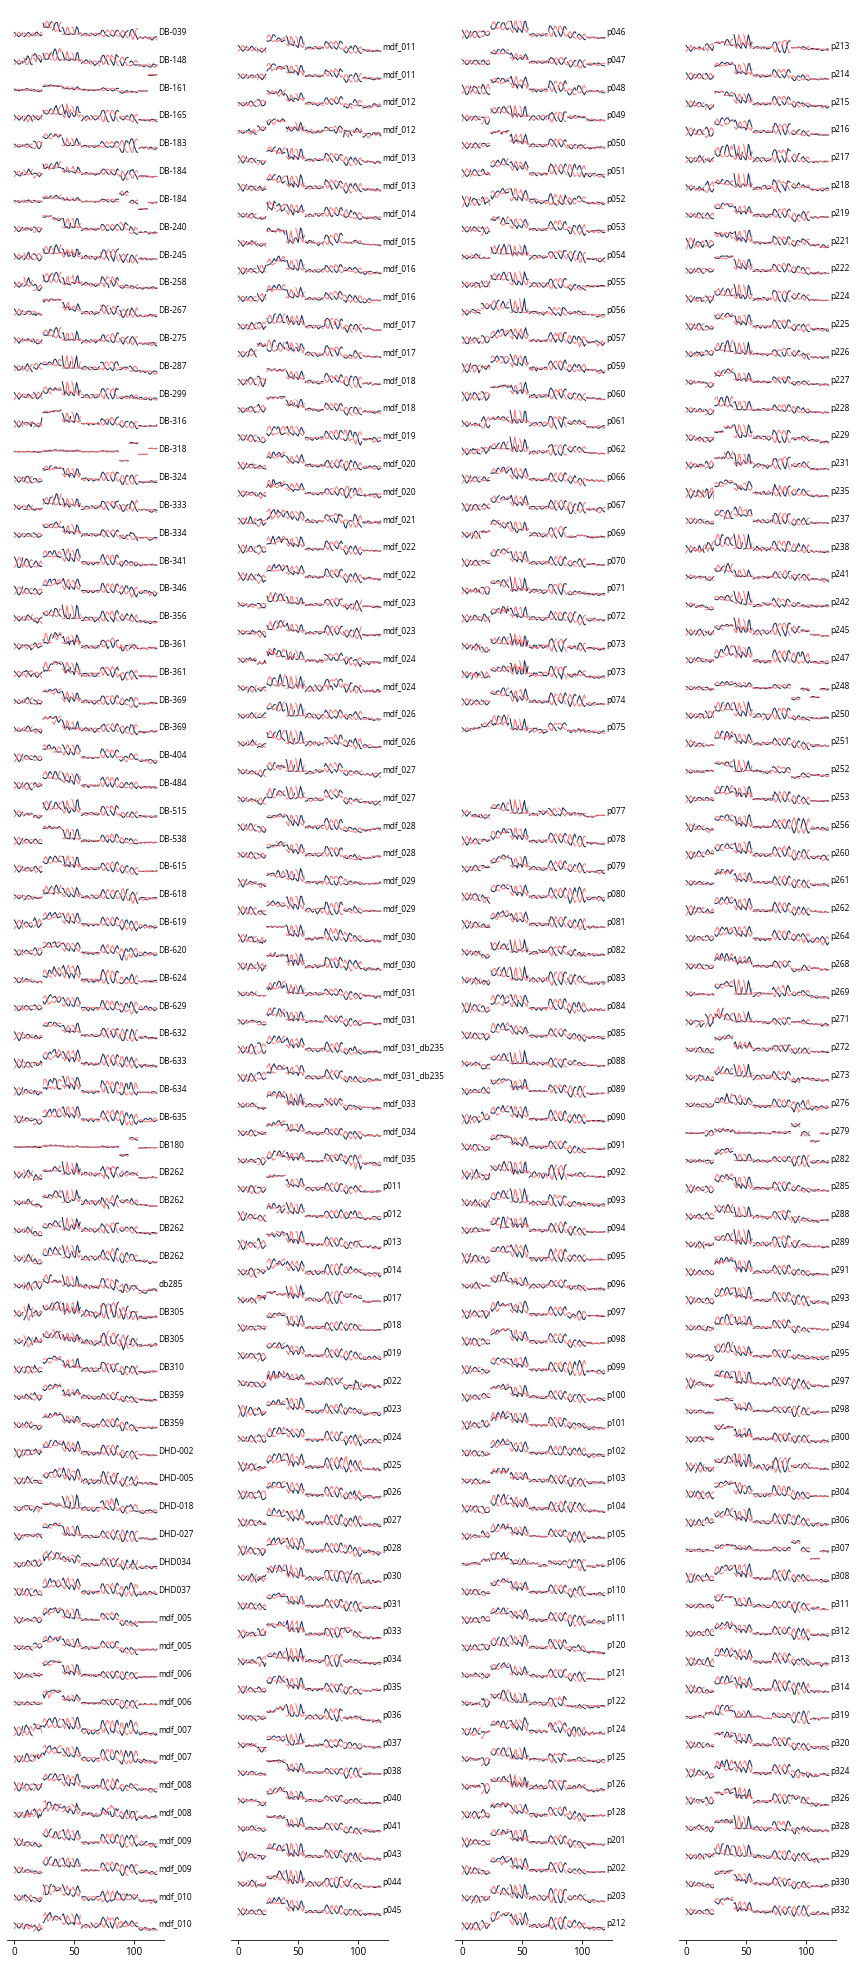

In [20]:
df_temp = df_trial[df_trial.trial_clean=='10mwrt'].copy()
n = len(df_temp)

ncols = 4

W = 8

plt.figure(figsize=(3*ncols,n/10))

rcats = []
lcats = []
pids = []
for i in trange(n, leave=False):
    row = df_temp.iloc[i]
    pid, sid, trial = row.pid, row.sid, row.trial

    if pid in ('p087', 'p076'):
    # if pid in ('p122'):
        continue
    
    sid, trial = row.sid, row.trial
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))
    df = read_mot(get_mot_fpath(sid, trial))
    
    rcat, lcat = gait_kinematics_cat(xyz, markers, fps, df, W)
    
    rcats.append(rcat)
    lcats.append(lcat)
    pids.append(pid)
    
    rcat /= rcat.ptp()
    lcat /= lcat.ptp()

    plt.subplot(1,ncols,int(i//(n/ncols)+1))
    for j in range(rcat.size // W):
        plt.plot(np.arange(W)+W*j, rcat[W*j:W*j+W]-i%(n/ncols)*1.5, c=cp[0], lw=1)
    for j in range(lcat.size // W):
        plt.plot(np.arange(W)+W*j, lcat[W*j:W*j+W]-i%(n/ncols)*1.5, c=cp[1], lw=1)
    plt.text(rcat.size, 0-i%(n/ncols)*1.5, pid, fontsize='small')
    plt.yticks([])
    plt.ylim(-(n/ncols)*1.5, 1.5)

rcats = np.vstack(rcats)
lcats = np.vstack(lcats)
    
sns.despine(left=True)
plt.tight_layout()
plt.savefig('demo_gait3.pdf')
plt.show()


In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import sklearn.metrics as skm

def loso(df, feats, label, clf, res_map, progress=False):
    df = df.copy()
    for holdout in tqdm(df.pid.unique(), leave=False, disable=(not progress)):
        idx_train = df.pid != holdout
        idx_test = df.pid == holdout

        df_train = df[idx_train]
        df_test = df[idx_test]

        X_train = df_train[feats].values
        y_train = df_train[label].values
        X_test = df_test[feats].values
        y_test = df_test[label].values

        if len(feats) == 0:
            X_train = np.ones((y_train.size, 1))
            X_test = np.ones((y_test.size, 1))

        clf.fit(X_train, y_train)
        for name, res_fun in res_map.items():
            res = res_fun(clf, X_test)
            if name not in df.columns:
                df[name] = np.object_()
                # df[name] = df[name].astype(object)
            # if df.loc[idx_test, name].shape == res.shape:
                # df.loc[idx_test, name] = res
            # else:
            #     for idx in df.index[idx_test]:
            #         df.at[idx, name] = res
            df.loc[idx_test, name] = res

    return df


def loso_linear_svc(df, feats, label, **kwargs):
    model = make_pipeline(StandardScaler(),
                          LinearSVC(**kwargs))
    res_map = {'score': lambda m, X: m.decision_function(X),
               'pred': lambda m, X: m.predict(X)}
    return loso(df, feats, label, model, res_map)


def loso_lda(df, feats, label, **kwargs):
    model = LinearDiscriminantAnalysis()
    res_map = {'score': lambda m, X: m.decision_function(X),
               'pred': lambda m, X: m.predict(X)}
    return loso(df, feats, label, model, res_map)


### PCA -> LOSO SVC

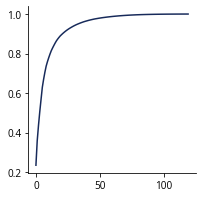

ValueError: Input contains NaN

In [22]:
from sklearn.decomposition import PCA
from matplotlib.colors import CenteredNorm

X = rcats[:,:].copy()

pca = PCA()
pca.fit(X)

plt.figure(figsize=(3,3))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

Xt = pca.transform(X)

types = []
for pid in pids:
    row = df_part[df_part.pid==pid].iloc[0]
    types.append(row.type)

data = {f'pca_{k:02}':Xt[:,k] for k in range(pca.n_components_)}
data['pid'] = pids
data['type'] = types
df_pca = pd.DataFrame(data)

# sns.stripplot(df_pca, x='type', y='pca_00')
# plt.show()

feats = [f'pca_{k:02}' for k in range(10)]
df_temp = df_pca[df_pca.type != 'FSHD']
df_res = loso_linear_svc(df_temp, feats=feats, label='type', max_iter=10000)

sns.stripplot(df_res, x='type', y='score')
plt.show()
print(skm.roc_auc_score(df_res['type'], df_res['score']))


feats = [f'pca_{k:02}' for k in range(10)]
df_temp = df_pca[df_pca.type != 'DM']
df_res = loso_linear_svc(df_temp, feats=feats, label='type', max_iter=10000)

sns.stripplot(df_res, x='type', y='score')
plt.show()
print(skm.roc_auc_score(df_res['type'], df_res['score']))


feats = [f'pca_{k:02}' for k in range(10)]
df_temp = df_pca[df_pca.type != 'CTL']
df_res = loso_linear_svc(df_temp, feats=feats, label='type', max_iter=10000)

sns.stripplot(df_res, x='type', y='score')
plt.show()
print(skm.roc_auc_score(df_res['type'], df_res['score']))



In [ ]:
feats = [f'pca_{k:02}' for k in range(10)]
df_temp = df_pca[df_pca.type != 'FSHD']
df_res = loso_lda(df_temp, feats=feats, label='type', max_iter=10000)

sns.stripplot(df_res, x='type', y='score')
plt.show()
print(skm.roc_auc_score(df_res['type'], df_res['score']))


# feats = [f'pca_{k:02}' for k in range(10)]
# df_temp = df_pca[df_pca.type != 'DM']
# df_res = loso_linear_svc(df_temp, feats=feats, label='type', max_iter=10000)

# sns.stripplot(df_res, x='type', y='score')
# plt.show()
# print(skm.roc_auc_score(df_res['type'], df_res['score']))


# feats = [f'pca_{k:02}' for k in range(10)]
# df_temp = df_pca[df_pca.type != 'CTL']
# df_res = loso_linear_svc(df_temp, feats=feats, label='type', max_iter=10000)

# sns.stripplot(df_res, x='type', y='score')
# plt.show()
# print(skm.roc_auc_score(df_res['type'], df_res['score']))
